# Bias and Variance of ridge regression

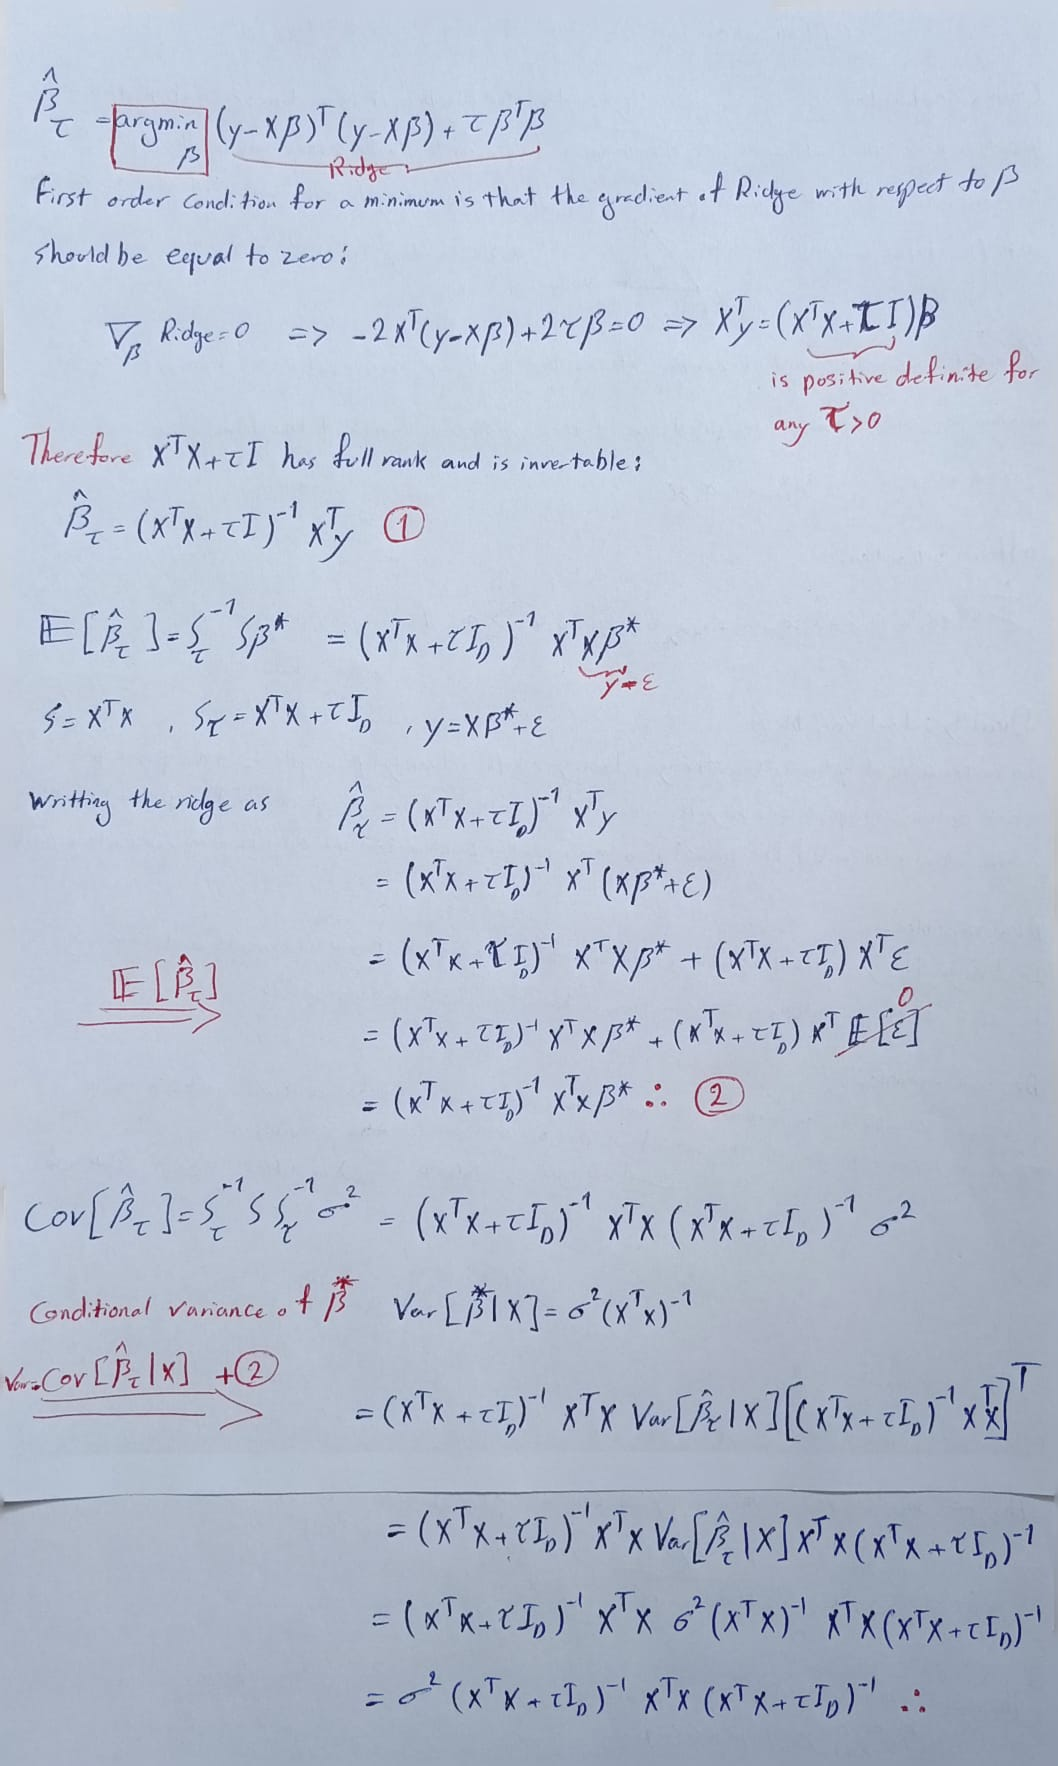

# Orthogonal Matching Pursuit

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [2]:
def omp_regression(X, y, T, standardize=False):
    '''
    Performs Orthogonal Matchin Pursuit.\n
    The labels in y need to consist of 1s and -1s.\n
    Output: betas: list of betas obtained with increasing number of active features\n
            A: list of active pixel indices sorted by importance
    '''

    N = X.shape[0] # number of measurements
    D = X.shape[1] # number of features
    A = []
    B = list(range(D))
    r = y

    if standardize:
        # Center data
        mean = np.sum(X, axis=0) / N
        X = X - mean

    # Limit number of iterations to number of features
    T = min(T, X.shape[1])

    betas = [] # the thing we want to return

    for t in range(T):
        # find remaining feature with largest correlation
        corrs = np.abs([X.T[j].dot(r) for j in B])
        ind = np.argmax(corrs)

        # check if correlation is too small
        if corrs[ind] < 1e-8:
            print(f"WARNING: Correlation too low at step {t+1}/{T}, stopping prematurely")
            break

        # make that feature active
        j = B[ind]
        A.append(j)
        B.remove(j)

        # solve OLS using only the active features
        X_t = X[:, A]

        N_pos = np.sum(y==1)
        N_neg = np.sum(y==-1)

        mu_pos = np.sum(X_t[y==1], axis=0) / N_pos
        mu_neg = np.sum(X_t[y==-1], axis=0) / N_neg

        shift_pos = X_t[y==1] - mu_pos
        shift_neg = X_t[y==-1] - mu_neg

        Sigma = (sum(np.outer(X_i, X_i) for X_i in shift_pos) + sum(np.outer(X_i, X_i) for X_i in shift_neg)) / N

        beta_t = np.linalg.inv(Sigma) @ (mu_pos - mu_neg).T
        r = y - X_t@beta_t

        betas.append(beta_t)
    
    return betas, np.array(A)

In [3]:
def predict_labels(X, beta):
    return np.sign(X @ beta)

In [4]:
def error_rate(X, y, beta):
    y2 = predict_labels(X, beta)

    N = X.shape[0]
    return np.sum(y != y2) / N

In [5]:
# copied from exercise sheet 1
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [6]:
mask_39 = (target==3) + (target==9) # only take data related to 3 and 9

data_39 = data[mask_39]
target_39 = target[mask_39]

In [7]:
X = data_39
y = (6 - target[mask_39]) // 3 # convert 3s and 9s to 1s and -1s

X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(X, y,
                                     test_size= 0.4, random_state = 0)

In [8]:
betas, A = omp_regression(X_train, y_train, 100)
betas_std, A_std = omp_regression(X_train, y_train, 100, standardize=True)

In [9]:
error_rates = [error_rate(X_test[:, A[:i+1]], y_test, beta) for i, beta in enumerate(betas)]
error_rates_std = [error_rate(X_test[:, A_std[:i+1]], y_test, beta) for i, beta in enumerate(betas_std)]

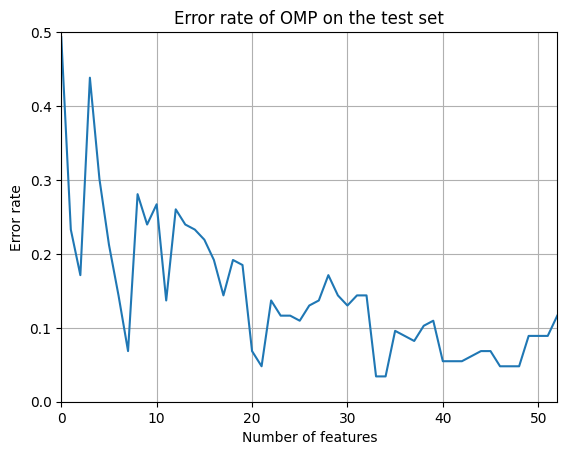

In [10]:
plt.plot(list(range(len(betas))), error_rates)
plt.xlim(0, 52)
plt.ylim(0, 0.5)
plt.title("Error rate of OMP on the test set")
plt.xlabel("Number of features")
plt.ylabel("Error rate")
plt.grid()

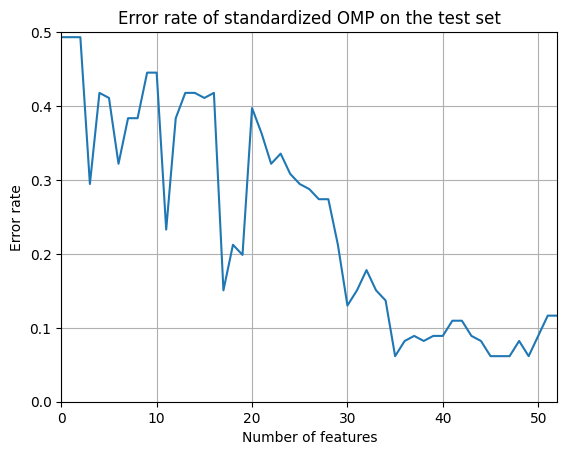

In [11]:
plt.plot(list(range(len(betas))), error_rates_std)
plt.xlim(0, 52)
plt.ylim(0, 0.5)
plt.title("Error rate of standardized OMP on the test set")
plt.xlabel("Number of features")
plt.ylabel("Error rate")
plt.grid()

The error rate drops below 10% at around 33 features, so this is the minimum number of pixels one should use. Standardizing the test set, i.e. centering it, worsens the error rate significantly

In [12]:
pixel_ind_3 = A[betas[-1] > 0] # pixel indices that vote in favour of 3
pixel_ind_9 = A[betas[-1] < 0] # pixel indices that vote in favour of 9

N_3 = pixel_ind_3.shape[0]
N_9 = pixel_ind_9.shape[0]

pixel_importance = np.zeros(X[0].shape)

for i, x in enumerate(pixel_ind_3):
    pixel_importance[x] = 1 - i/N_3

for i, x in enumerate(pixel_ind_9):
    pixel_importance[x] = i/N_9 - 1

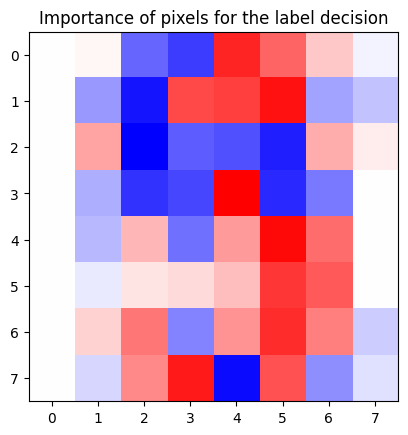

In [13]:
plt.imshow(pixel_importance.reshape((8, 8)), cmap="bwr")
plt.title("Importance of pixels for the label decision")
plt.show()

Above you can see the importance of pixels for the label decision. Blue pixels vote in favor of 9 and red pixels vote in favor of 3. Darker pixels are more significant, i.e. get activated sooner. The most significant criterion seems to be the blue cluster of pixels towards the top left corner, which is where 3 and 9 differ in most handwritings.

In [14]:
A[:6]

array([18, 60, 10, 21, 28, 29])

As you can see, the most significant pixels have indices [18, 26, 29, 36, 21, 30]. This is very similar to the pixels we chose for exercise sheet 1, namely [18, 26, 29, 36, 21, 4]